## The dataset and packages

You can find the data used in this project here: https://www.kaggle.com/datasnaek/chess . This dataset contains  20,058 records and 16 variables. The original kaggle poster took these data from lichess.org. Each record corresponds to a chess match, and all records were taken from the top 100 teams playing on lichess.org. 

We will mostly use Python's data packages (pandas, sci-kit, etc.). Otherwise, we will be using my own python module (chess_utility, also in this folder) that contains more complex code. For Jupyter Notebook users, recall you can type any function signature followed by ?? to see the full function source code and documentation.  

In [1]:
import pandas as pd
import numpy as np



import seaborn as sns
sns.set_style("dark")    # Because we're cool
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2
import chess_utility as cu

Here we can see a small random portion of the data. 

In [3]:
games = pd.read_csv('games.csv')

In [4]:
NUMROWS = 2
cu.sample_entries(games, NUMROWS, games.columns)

,id,rated,created_at,last_move_at,turns,victory_status,winner,increment_code,white_id,white_rating,black_id,black_rating,moves,opening_eco,opening_name,opening_ply
186,hl3zLZmV,False,1.501200e+12,1.501200e+12,110,resign,black,10+0,isachess,1845,nicolo97,1917,d4 d5 c4 Nf6 Nc3 Bf5 Nf3 e6 e3 Bb4 Qa4+ Nc6 cx...,D06,Queen's Gambit Refused: Marshall Defense,4
13021,0wkPVyCT,False,1.499158e+12,1.499159e+12,45,mate,white,15+15,musimustang,1073,ashok-arora,1226,d4 e6 e3 Nc6 Nc3 Nf6 Nf3 Bb4 Qd2 Nd5 Bb5 Na5 B...,A40,Horwitz Defense,2


The variables do an excellent job of explaining themselves. Non-chess players, however, might need some insight into what a few of these variables measure. 

- Turns refers to the number of turns the game has undergone. One full turn is two moves since each player moving once counts as a turn. 
- The increment_code variable refers to time increments in a game. Most chess games nowadays have a time limit for each player to make their moves. Time increments indicate how much extra time a player acquires when it's their turn to move. For example, a time increment of 15 + 0 indicates each player has 15 minutes to make all their moves, and 0 seconds will be added to their elapsed time each time it's their turn to move. A time increment of 15 + 10 indicates the same thing, except now, each time it's a player's turn, they will get a bonus 10 seconds on the clock. 
- Note that the opening_eco refers to a specific code used to classify a chess opening, the first few moves in a chess game. 
- White_id and black_id refer to usernames for the players on lichess.org. 
- Finally, white_rating and black_rating correspond to the strength level of a player. A higher number indicates a stronger player. Lichess.org use the Glicko2 system for their ratings. 

After glancing over our stock of variables, we swiftly check for dreaded missing values in each of them.

In [5]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20058 entries, 0 to 20057
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              20058 non-null  object 
 1   rated           20058 non-null  bool   
 2   created_at      20058 non-null  float64
 3   last_move_at    20058 non-null  float64
 4   turns           20058 non-null  int64  
 5   victory_status  20058 non-null  object 
 6   winner          20058 non-null  object 
 7   increment_code  20058 non-null  object 
 8   white_id        20058 non-null  object 
 9   white_rating    20058 non-null  int64  
 10  black_id        20058 non-null  object 
 11  black_rating    20058 non-null  int64  
 12  moves           20058 non-null  object 
 13  opening_eco     20058 non-null  object 
 14  opening_name    20058 non-null  object 
 15  opening_ply     20058 non-null  int64  
dtypes: bool(1), float64(2), int64(4), object(9)
memory usage: 2.3+ MB


At the top of the output, we see 20058 entries for the entire data set. If we pore over the second column, *non-null count*, we see no variable has missing values since all demonstrate 20058 as their non-null count. So we can safely conclude our data set has no missing values. 

Before performing an exploratory data analysis (EDA) on our dataset, we will define a predictive question for the set and then perform an EDA for the variables that interest us. 

## The predictive mega question

After poring over the data, we are seduced by the idea of predicting the outcome of a chess match using player ratings. A chess rating (see above, white_rating and black_rating) indicates strength of a player. After signing up on the site, lichess.org gives a user a provisionary rating of 1300. As they play more games, the user gets a more accurate rating. Since all of our matches come from the top 100 teams in lichess.org, we can assume these ratings reflect player strengths well. 

So, how could we use ratings to predict the outcome of a match? The simplest way is by taking a difference between two ratings. Low differences indicate evenly matched players while high differences suggest unevenly matched players. We would aim to predict the outcome of a match based on this difference. Particularly, we could show a probabilty of winning for each player based on the difference between their ratings.  

It might also be useful to consider turns and "whiteness" of a player. Supposing a match had been going on for 5 turns, this might inform how likely a player is to win versus a match having been going on for 20 turns. Whiteness also matters since white is first to move in a game. So, playing as white against a higher rated player might up your chances of winning. 

Our question, thus, can be concisely worded as the following: can we use ratings, number of turns, and whether a player is white to assign a probability of winning to each player in a chess match?

*Nothing up this sleeve, and nothing up this sleeve* so we'll jump right in.

## Cooking new variables

To answer our predictive question, we make new variables to work with. 

1) abs_diff_rating will take the absolute value of the difference in rating between two players. An absolute value makes sense in our context since we'll only be interested in the magnitude of difference between two player ratings.

In [6]:
games['abs_diff_rating'] = np.abs(games.white_rating - games.black_rating)

2) higher_rating_won will be a binary variable taking 1 if the person with the higher rating won, and 0 if they didn't. We'll use this variable when running a binary model. 

In [7]:
# To make higher_rating, I make a variable that determines who won - white or black, or if the match was a draw. 
games[ 'higher_rating' ] = ''
games.loc[ games.white_rating - games.black_rating > 0, 'higher_rating' ] = 'white'
games.loc[ games.white_rating - games.black_rating < 0, 'higher_rating' ] = 'black'
games.loc[ games.white_rating - games.black_rating == 0, 'higher_rating' ] = 'same'

In [8]:
games[ 'higher_rating_won' ] = 0
games.loc[ games.winner == games.higher_rating, 'higher_rating_won'] = 1

3) result will encode whether the higher rated player lost, tied, or won (0, 1, 2). We'll use this variable when running a three class classifier. 

In [9]:
games[ 'result'] = 0
games.loc[ games.winner == 'draw' , 'result'] = 1
games.loc[ games.higher_rating_won == 1, 'result'] = 2

4) white_higher_rated encodes whether the higher rated player was white or not (1, 0). 

In [10]:
games[ 'higher_rated_white' ] = 0
games.loc[ games.higher_rating == 'white', 'higher_rated_white' ] = 1

Here's a look at a random sample of our data set for the variables we created. We also include variables in the call out to check the variables were created properly.

In [11]:
made_variables = [ 'abs_diff_rating', 'higher_rating_won','result', 'higher_rated_white' ]
comparison_variables = [ 'winner', 'white_rating', 'black_rating' ]
cu.sample_entries( games, NUMROWS, made_variables + comparison_variables )

,abs_diff_rating,higher_rating_won,result,higher_rated_white,winner,white_rating,black_rating
10399,67,1,2,1,white,1515,1448
10943,9,0,0,0,white,1445,1454


*Note: since each call to sample_entries is random, you can run the cell above repeatedly to get different samples from the dataset.*

Next, we'll drop all other variables and be left with a spartan dataset containing only the variables interesting to us. 

In [12]:
new_variable_indices = [ games.columns.get_loc( column ) for column in made_variables ]

In [13]:
modified_games = games.iloc[ :, new_variable_indices ].copy()

In [14]:
modified_games[ 'turns' ] = games[ 'turns' ]

In [15]:
# Check work 
modified_games.head()

,abs_diff_rating,higher_rating_won,result,higher_rated_white,turns
0,309,1,2,1,13
1,61,0,0,1,16
2,4,0,0,0,61
3,15,0,0,0,61
4,54,1,2,1,95


We then save this modified version of the dataset and reset the games variable to reflect the modified version. 

In [16]:
modified_games.to_csv( 'modified_games.csv' )

In [17]:
games = modified_games

## Exploratory Data Analysis

In this section, we examine our variables of interest with a statistical magnifying glass. 

### Absolute value in differences
We'll start by checking out our abs_diff_rating variable. 

In [18]:
games.abs_diff_rating.describe()

count    20058.000000
mean       173.091435
std        179.214854
min          0.000000
25%         45.000000
50%        115.000000
75%        241.000000
max       1605.000000
Name: abs_diff_rating, dtype: float64

A brief look at the read out lets us know most observations had an absolute difference of up to 241 points (third quantile reading). Below, we can see a histogram of this distribution. 

Text(0.5, 0, 'Absolute Value Difference in Rating')

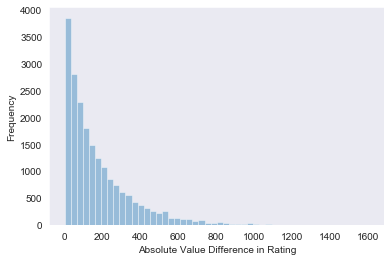

In [19]:
sns.distplot(games.abs_diff_rating,
                        kde=False)
plt.ylabel('Frequency')
plt.xlabel('Absolute Value Difference in Rating')

We've got a right skewed distribution of absolute values in rating. The skew shows how most games took place between players having smaller absolute difference in rating. In other words, less matches take place between players having high absolute differences in their ratings. This is easy to see when you compare the frequencies from 0 to 200 with frequencies from 600 to 800 for example.  

A box plot helps us visualize possible outliers.

Text(0.5, 0, 'Absolute Value Difference in Rating')

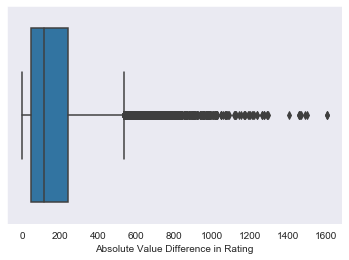

In [20]:
sns.boxplot(x="abs_diff_rating", data=games)
plt.xlabel('Absolute Value Difference in Rating')

It looks like at around the 600 absolute value difference, we have a hoard of high outliers. We need not, however, remove them yet since they could inform how large differences contribute to percentages of winning. Note that we don't have low outliers since all of our values are positive. 

Do we give the outliers the boot? Nope. Seeing high absolute differences makes sense since matches get created randomly in lichess.org. Also, high absolute differences could inform the probability for match outcomes. 

### Higher Rating Won

We are interested in checking out how often the higher rating won since this will be one of our response variables when predicting. 

Text(0.5, 0, 'Higher Rating Won')

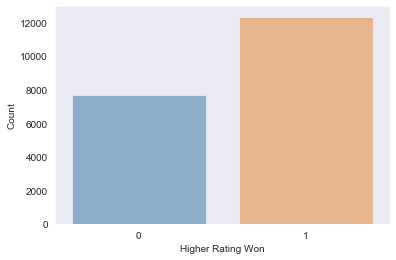

In [21]:
sns.countplot(x = 'higher_rating_won', data = games,  alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Higher Rating Won')

Below is a specific numerical proportion.

In [22]:
games.higher_rating_won.value_counts(1)

1    0.615814
0    0.384186
Name: higher_rating_won, dtype: float64

So 61% of the time, the higher rating won.

### Number of turns

We also check out the distribution for the number of turns taken. 

Text(0.5, 0, 'Turns')

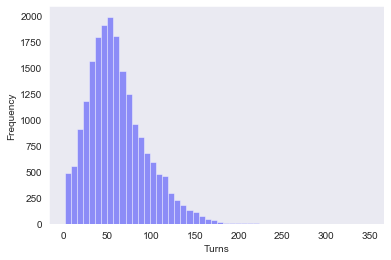

In [23]:
sns.distplot(games.turns, kde = False, color = 'b')
plt.ylabel('Frequency')
plt.xlabel('Turns')

Looks like most turns hover around 50. A numerical distribution is shown below.

In [24]:
games.turns.describe()

count    20058.000000
mean        60.465999
std         33.570585
min          1.000000
25%         37.000000
50%         55.000000
75%         79.000000
max        349.000000
Name: turns, dtype: float64

We get a mean and a median that are similar at 60 (rounded down from 60.46 since turns have to be whole numbers) and 55 respectively. Seeing 349 for a max number of turns makes me curious (that's a pretty long game). What more can I say about that match?

In [25]:
games.iloc[games.turns.max()]

abs_diff_rating        20
higher_rating_won       0
result                  0
higher_rated_white      1
turns                 120
Name: 349, dtype: int64

The players had similar ratings showing only 20 points difference. Also, black won since the higher_rated_won variable lets us know the higher rated (white) player didn't win. 

Don't know if you noticed saw this, Watson, but we had a minimum of 1 for turns (see our output for numerical description of turn data). This is alarming since a 1 turn game would probably not provide useful information. 

We need to determine a good cut off for how many turns is acceptable in our set. In chess, the fastest check mate is called the Fool's Mate and can happen in two turns. So a cut off of two turns for a likely game would be acceptable for a realistic match. 

We can check how many games lasted less than two turns. 

In [26]:
len( games.loc[ games.turns < 2 ] )

18

Let's remove games with less than 2 turns from our data. 

In [27]:
games.drop(games[games.turns < 2].index, inplace = True)

### Result 

Finally, let's look at the result variable. Recall that this variable encodes whether the higher rated player lost (0), drew (1), or won (2). 

Text(0.5, 0, 'Result')

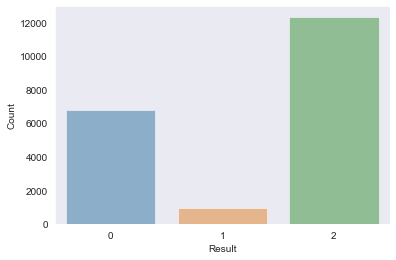

In [28]:
sns.countplot(x = 'result', data = games, alpha = 0.5)
plt.ylabel('Count')
plt.xlabel('Result')

For the higher rated player, we have mostly wins (2), a little more than half of these are losses (0), and a small proportion turn out to be draws (1). We can see numerical proportions below.

In [29]:
games.result.value_counts(1)

2    0.615669
0    0.336926
1    0.047405
Name: result, dtype: float64

The higher rated player won 61% of the time (reflecting our binary variable higher_rated_won), lost 34% of the time, and drew about 5% of the time.

### Exploratory Data Analysis Summary

1) We need not worry about low outliers in the absolute value of differences between ratings. High outliers, however, do exist according to our definition of boxplot outliers. We choose to brave them in our set since high absolute differences could inform a probabilitities for match outcomes.

2) For the higher rated player, most of the games end up as wins ~61%, then losses ~34%, and a tiny percentage of the matches are draws ~5%. 

3) The turns variable revealed short turn games, and we removed any matches that had less than 2 turns. 

Since we removed short turn matches, we will re-write out the dataset for later use. 

In [30]:
games.to_csv('modified_games.csv')

## Getting the plan straight

After going through that grand EDA, we'll cook up a plan for constructing our models.  

Recall our question: *can we use ratings, number of turns, and whether a player is white to assign a probability of winning to each player in a chess match?*  In terms of our variables, this means that we will use abs_diff_rating, turns, and higher_rated_white to assign a probability to each class for higher_rating_won (in the binary case) or result (in the three class case). We can then use these probabilities to make predictions. 

We'll construct four different models: a logistic regression, a bag of trees, and a random forest. We'll first compare how these procedures compare to each other using stratified k fold cross validation. Then, we'll fit each model and show how they predict outcomes. 

For the algorithmically rusty, let's take a look at how these models work before using them.  

## Logistic Regression

A logistic regression is one of the first kids on the block you meet when trying to classify a binary response variable. 

Taking the math to town, we can set up a simple logistic regression equation as follows. Let $X_1, X_2, X_3$ be predictors and $Y$ a target variable having two classes. In our case, we can imagine that $X_1$ is abs_diff_rating, $X_2$ is turns, $X_3$ is white_higher_rated. Our $Y$ will higher_rated_won. What is the probability of seeing a particular class of $Y$ given $X$? Notationally, we can reword this as $P(Y_{class} | X)$. 

A logistic regression tells us that 
\begin{align}
P(Y_{class} | X) = \frac{ e^{\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3} }{1 + e^{\beta_0 + \beta_1X_1 + \beta_2X_2 + \beta_3X_3}}.
\end{align}


The $\beta$'s in the equation get picked by the least squares solution to this problem. Most softwares do all of the $\beta$ work for us, and we need not worry about manually calculating these. 

Having these probabilities enables predictions. Say, for example, that an observation results in a probability of seeing a win in higher_rated_won of 0.6. Since this is greater than or equal to 0.5, we would predict a win for this observation. Observations resulting in probabiliies less than 0.5 get assigned a loss prediction. At the end of the modelling procedure, we check out how badly the model performed comparing its predictions to true values. 

## Tree Methods

### Classification decision tree

A classification decision tree does as its name suggests. It makes decisions and grows leaves. In our particular case, recall that we're trying to predict a win or loss  using abs_diff_rating, turns, and white_higher_rated. A decision tree splits up the observations based on what groups show higher propensities in a certain class. For example, suppose that observations showing a high abs_diff_rating of 1000 seem to mostly have a win entry for highest_rated_won. Then, the tree will split observations into those having a abs_diff_rating value > 1000 and those observations such that abs_diff_rating value < 1000. Then, any observation falling into the category of having an abs_diff_rating > 1000 get a win predicted for highest_rated_won. For observations less than 1000, we may continue splitting on the same variable, or using turns and white_higher_rated.  

The choice of where to split the observations matters. In the classification setting, we use information gain (IG) or gini gain (GG) to determine the best split. Since these measures are similar, we'll just pick one and fly with it (GG). After we perform all the splits, we'll be left with what looks like an upside down tree (root at the top, leaves at the bottom). Each leaf or bottommost node of a tree defines a prediction for a set of observations. Thus, every observation in that node would receive the same prediction. After getting our hands on the predictions, we compare them with true values to see how wrongly everything went. 

Decision trees rock boats because they're easy to visualize and sometimes mirror human decision making. When modelling using a decision tree (see below), we'll show a visualization that should also help to understand the concept. 

### Bag of trees

Sometimes one thing won't work well. But trying a lot of one thing might give better results. A bag of trees does this. It uses a lot of decision trees to make its predictions. The process goes like this: fit a set number of trees, say 100, on the data. Now, take an observation and find predictions for it using those 100 different trees. Then, find the most commonly occuring prediction (majority vote count) and assign it as the bag's prediction for that observation. Do this for all data you want to find predictions for. 

Why do we use bags? Besides, of course, a single decision tree not predicting well, we might be concerned because a single decision tree predicts *too* well. Decision trees get intimate with their data and can sometimes give excellent predictions for a particular data set. If, however, we take that same tree and give it another dataset, it may perform poorly because it grew to attached to the first dataset. A bag of trees aims to fix this. By taking a majority vote of predictions from various trees, we limit the possibility of using any one tree too much. For mah geeks in the house, this is a perfect example of a bias-variance trade-off where we accept more bias to get rid of variance. 

### Random forests

There's more. Suppose a particular variable, say abs_diff_rating, works well in predicting higher_rated_won and another variable, say turns, doesn't. It's possible that a tree might include both abs_diff_rating and turns, but the better performing abs_diff_rating masks the poor performance of turns. Bags don't correct for this since each tree can grow using all the variables in the dataset. 

Random forests fix this by saying nope. They, like bags, aggregate trees, but deny the using of all variables to fit each tree. Instead, they allow each tree to use a subset of the variables. Usually, in the case of $p$ variables, they allow for $m$ variables where $m = \sqrt{p}$. 

## Comparing the models 

In this section, we'll be fitting a particular model multiple times on the data and averaging its results to check how it compares to other models. 

### Stratified K fold cross validation

In supervised learning algorithms, we work with a training data set and a test data set. We fit/train our model on the training data set, then see how it performs on the test set. In practice though, we may have only one dataset. So we get clever, and we make an "artificial" test set by splitting up our available dataset into a training set and testing set. This is the essence of cross validation. 

In K fold cross validation, we cut up our data set into K folds or groups. Then, we hold one fold out, and we train the model on the other folds. We then test the model on the fold we left out. We do this K times, alternating each fold as the test set. This process helps us form a better picture of how well the model works. 

Sometimes one class dominates other classes in a dataset. For example, in our dataset, the result variable shows many wins, less losses, and even fewer draws. 

In [31]:
games.result.value_counts(1)

2    0.615669
0    0.336926
1    0.047405
Name: result, dtype: float64

A draw (entry of 1) only occurs about 4% of the time in our dataset. This means that if we just apply a K fold cross validation, some folds may end up not having any draws at all to fit the models on so our model won't know how to react (speaking anthropomorphically here) when it does see a draw. 

Stratified K fold cross validation aims to fix this issue by ensuring that each fold proportionately contains all classes. In other words, if we have draws 4% of the time in the entire dataset, then approximately 4% of each fold should be draws. Since our dataset has skewed classes, it makes sense to check how well a model runs using this method. 

### Cooking up binary models

#### Response setting, and other params
We'll knight these predictors with a big 'X' for a name. 

In [32]:
from sklearn.preprocessing import normalize
X = normalize(games[ [ 'abs_diff_rating', 'turns', 'higher_rated_white' ] ])

In [33]:
games = pd.read_csv('modified_games.csv')

We set up a response and give it a wildly descriptive 'y'. 

In [34]:
y = games[ 'higher_rating_won' ]

Some of the algorithms below automatically randomize. So, if we're not careful, we could end up always getting different numbers for the model results. By setting a RANDOM STATE, we can pick a result and stick with throughout the analysis. Also, when we cross validate using K fold cross validation we will specify 10 folds through NUMBER FOLDS. 

In [35]:
RANDOM_STATE = 1
NUMBER_FOLDS = 10

#### Logistic regression

We will begin with a Logistic Regression. 

In [36]:
lg_confusion_matrix = cu.run_logistic_regression(NUMBER_FOLDS, X, y, RANDOM_STATE)
lg_results = cu.get_cm_results(lg_confusion_matrix)

#### Tree based methods

Next up, we fit a bag of trees to our data. In the case of fitting a bag of trees and a random forest, we will use 100 estimators. This means that we will be using 100 trees in each case to build the models. 

In [37]:
NUMBER_ESTIMATORS = 100

In [38]:
bag_confusion_matrix = cu.run_bag_trees(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)
bag_results = cu.get_cm_results(bag_confusion_matrix)

In [39]:
r_forest_confusion_matrix = cu.run_random_forest(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)
r_forest_results = cu.get_cm_results(r_forest_confusion_matrix)

#### Results readings

A whole tribe of metrics based on a confusion matrix exist. We'll acquire these then plot these to determine model performance.

In [40]:
accuracy, precision, recall, fmeasure, specificity, negative_pv = cu.group_important_results(lg_results, bag_results, r_forest_results)

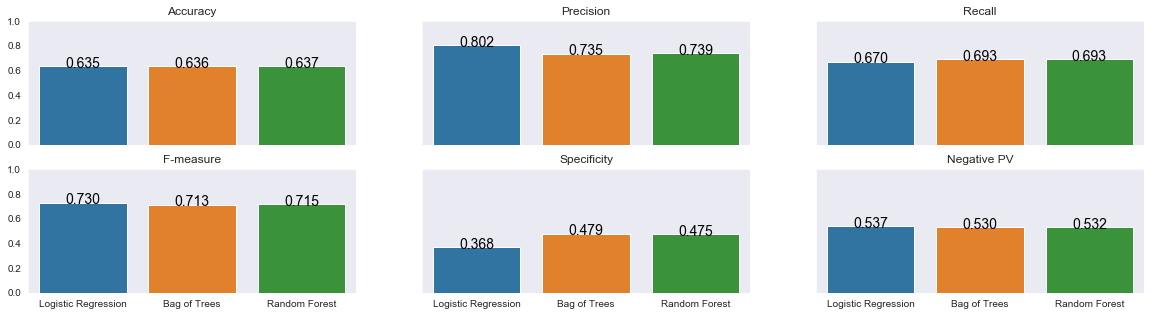

In [41]:
cu.create_specific_results_plot(r_forest_results, lg_results, bag_results, 3, 2) # 3 cols, 2 rows

We've got six different metrics to chew on here so put on your seat belt. 

- First, is accuracy. This is a general metric. It tells us how often the model correctly predicts the value. All models seem to hover at around 63% of accuracy. In other words, the models make a correct prediction 63% of the time. 

- Second, is precision. It is the proportion of correctly predicted wins to the number of total win predictions. Here, the Logistic Regression pulls ahead at 0.802 and says cheers to the other two models.  

- Third, is recall. This tells us how many of the true wins our model predicted accurately. Our models seem to hover between 67% and 69%. 

- Fourth, is the fabulous fmeasure. This combines precision and recall into one spiffy measurement. In our case, it looks like most models hover between 71% and 73%. 

- Fifth, is specificity. The specifics on specificity are simple. The measure infroms about losses. In particular, out of the times we predicted a loss how often were we right? And, goodness gracious the Logistic Regression just sags here at about 37% compared to the others at around 47%. 

- Finally, we got negative pv. This is short for negative predictive value, and this tells us what percentage of true losses our models caught. Most of the models do equally pitifully at around 53%.  

##### Conclusion
So what can we say? These models perform similarly across most measurements. The models do splendidly when they predict wins (Logistic Regression in particular), but they trip awkwardly when predicting losses (Logistic Regression in particular). 

We could also compare with the null rate. This measures the accuracy if we just predicted every response to the dominant class. Using different word words, this is the accuracy of a model that simply predicts a win no matter what. 

In [42]:
null_rate = np.abs( (y - 1 ).sum() ) / len( games )
null_rate

0.3843313373253493

It is cute, and encouragingly, worse than the accuracy of any of our models above. 

We also show plots for each model packaged with its confusion matrix measurements.

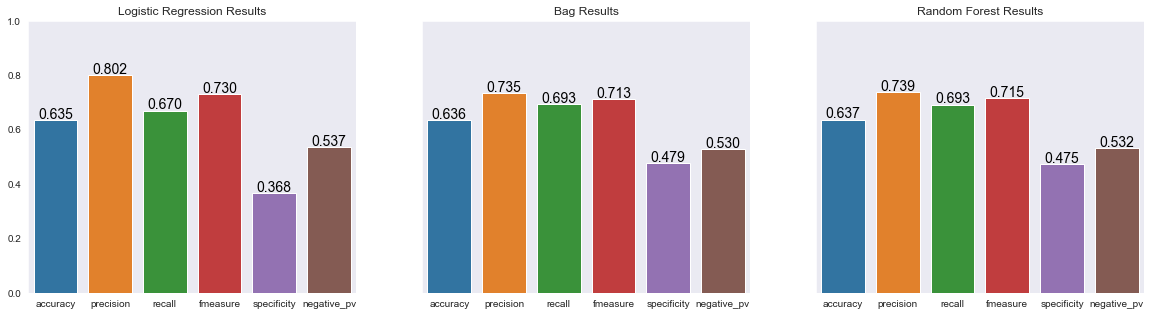

In [43]:
cu.create_cumulative_results_plot(r_forest_results, lg_results, bag_results)

The take away for this section is that these models perform similarly. Logistic Regression perferms slightly better in precision, but sacrifices specificity. 

### Beyond binary 

In this section, we go further. We refit our tree based models with our response as 'result'. Recall this encoded whether games were a loss, draw, or win for the higher rated player. We eschew trying a three class classification with a logistic regression because it isn't a popular choice for three class problems. 

In [44]:
y = games['result']

#### Bag those Trees

We kick it off again with a bag of trees. Here, we also run stratified 10 fold cross validation.  

In [45]:
bag_multi_confusion_matrix = cu.run_bag_trees(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)

We also fit the random forest in exactly the same way. 

In [46]:
r_forest_multi_confusion_matrix = cu.run_random_forest(NUMBER_FOLDS, NUMBER_ESTIMATORS, RANDOM_STATE, X, y)

We can start by comparing the accuracy of our two models. 

In [47]:
r_forest_accuracy = cu.get_accuracy_three_class( r_forest_multi_confusion_matrix )
bag_accuracy = cu.get_accuracy_three_class( bag_multi_confusion_matrix )
accuracies = {'Random Forest': r_forest_accuracy, 'Bag of Trees': bag_accuracy}

(0, 1)

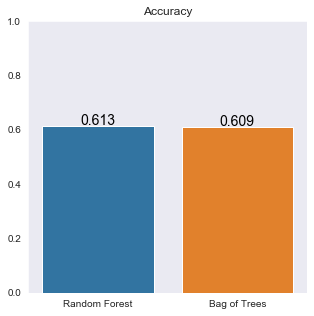

In [48]:
fig, axs = plt.subplots(figsize=[5, 5], gridspec_kw={'wspace': 0.2})
cu.create_bar_results(accuracies, 'Accuracy', axs)
plt.ylim([0, 1])

Our hearts say 'bummer'. They classify correctly about 60% of the time. We, however, don't immediately lose hope since maybe more specific metrics will uplift us. 

In a three class confusion matrix, we usually consider precision and recall for each class. So, we'll join the herd and do so as well. 

##### Loss

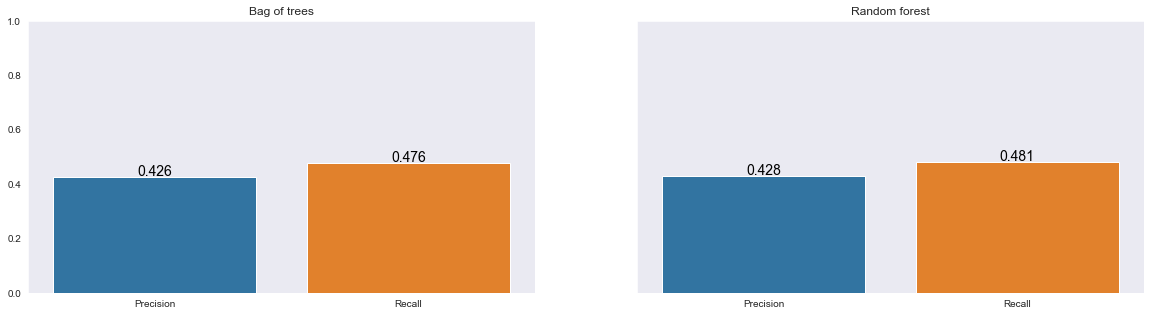

In [49]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 0 )    # 0 for loss

Uncannily, the precision and recall is quite similar for the bag and forest. This considers the losses predicted by the model. So, when we predict a lost, we are right around 43% of the time (precision). But out of all the losses we should've predicted, we only got 48% (recall). 

##### Draw

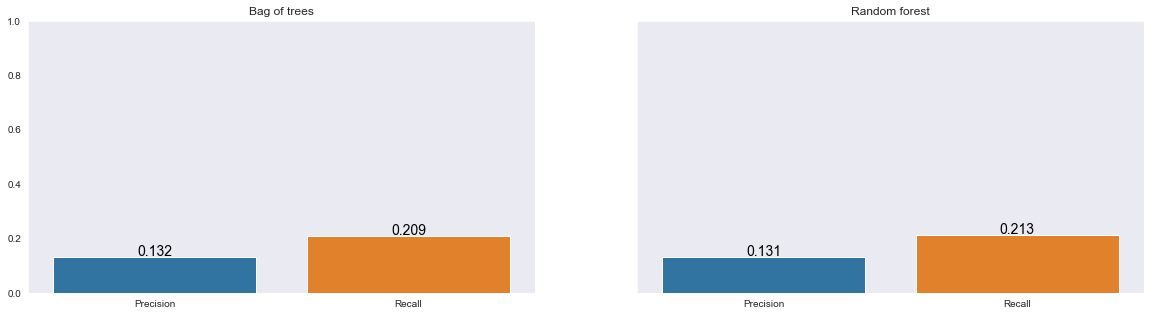

In [50]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 1 )    # 1 for draw

Egad. Our models sink to new lows when trying to predict a draw between the two players. When we predict a draw, we are right about 13% of the time (precision). Also, out of all the draws we should've predicted, we only got 20% (recall). 

##### Winning

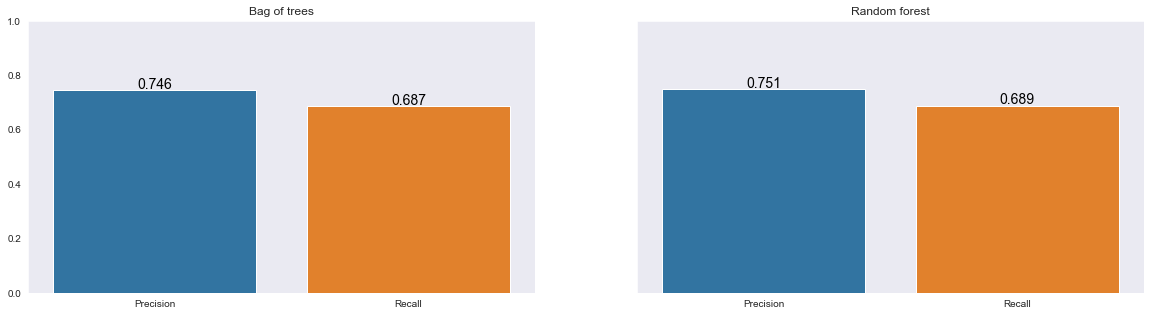

In [51]:
cu.make_plot_multi_label( bag_multi_confusion_matrix, r_forest_multi_confusion_matrix, 2 )    # 2 for win

Applauds wildly! Our models rise to new heights when predicting wins. When we predict a win, we are right around 75% of the time (precision). But out of all the wins we should've predicted, we only properly predicted 68% (recall). 

##### Conclusion

So, we can say our model wins at predicting wins, loses at predicting losses, and jumps off a cliff when trying to predict draws. 

## The models in action

Now that we've compared the models to each other, we can fit the models and see how they make their predictions.  

In [52]:
y = games[ 'higher_rating_won' ]    # Back to binary

In [53]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = RANDOM_STATE)    # Specify random state

### Logistic Regression

In [54]:
from sklearn.linear_model import LogisticRegression
lg = LogisticRegression()
lg.fit( X_train, y_train )

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

We can now see how the logistic regressoin makes a prediction. We'll start by seeing how two players match up to each other at the start of the game. 

In [55]:
abs_diff_rating = 100
turns = 0
white_higher_rated = 1

In [56]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

So, if the player's have a difference of a 100 points between them, then the higher rated player has a 66% of winning. 

In [57]:
turns = 50

In [58]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

Interestingly enough, if more turns have happened, then the probability of the higher rated player falls to 61%. 

In [59]:
turns = 150

In [60]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

Whoa! If our players have been duking it out for 150 turns, our model suggests only a 50% chance of winning for the higher rated player. Intuitively, this makes sense since a longer game indicates more even matching. 

We could also make the difference in rating be higher. 

In [61]:
abs_diff_rating = 500
turns = 0

In [62]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

Radical! 

We could also see how being white affects the higher rated player. 

In [63]:
white_higher_rated = 0

In [64]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

It looks like not being white lowers the higher rated player's chance of winning by 2%.  

In [65]:
abs_diff_rating = 100
white_higher_rated = 1

In [66]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

In [67]:
white_higher_rated = 0

In [68]:
cu.probability_with_lg( lg,  abs_diff_rating, turns, white_higher_rated)

0.0

However, changing who is white at a lower difference in rating shows a 4% decrease in the chance of winning. 

### Tree based methods

Since a bag of trees and a random forest aggregate trees, visualizing these models doesn't result in anything particularly gratifying. Instead, we can try to visualize a single decision tree taken from these models. 

#### Tree from a bag 

In [157]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
tree = DecisionTreeClassifier()
bag = BaggingClassifier( base_estimator = tree, n_estimators = NUMBER_ESTIMATORS, random_state = RANDOM_STATE )
bag.fit( X_train, y_train )

BaggingClassifier(base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                        class_weight=None,
                                                        criterion='gini',
                                                        max_depth=None,
                                                        max_features=None,
                                                        max_leaf_nodes=None,
                                                        min_impurity_decrease=0.0,
                                                        min_impurity_split=None,
                                                        min_samples_leaf=1,
                                                        min_samples_split=2,
                                                        min_weight_fraction_leaf=0.0,
                                                        presort='deprecated',
                                                        random_state=None,


In [160]:
bag_sample_tree = bag.estimators_[0]

In [ ]:
import sklearn.tree as t
t.plot_tree( bag_sample_tree )

[Text(180.09652074437102, 215.7673846153846, 'X[0] <= 0.888\ngini = 0.47\nsamples = 10176\nvalue = [6054, 9978]'),
 Text(80.81741711439349, 212.42215384615383, 'X[1] <= 1.0\ngini = 0.5\nsamples = 4907\nvalue = [3768, 3942]'),
 Text(80.67395601245295, 209.07692307692307, 'X[1] <= 0.823\ngini = 0.499\nsamples = 4810\nvalue = [3617, 3942]'),
 Text(22.04999097387672, 205.7316923076923, 'X[1] <= 0.477\ngini = 0.49\nsamples = 2438\nvalue = [1656, 2203]'),
 Text(3.1830431993060344, 202.38646153846153, 'X[0] <= 0.883\ngini = 0.496\nsamples = 118\nvalue = [98, 82]'),
 Text(1.5063415703758136, 199.04123076923076, 'X[2] <= 0.008\ngini = 0.437\nsamples = 42\nvalue = [44, 21]'),
 Text(1.1476888155244294, 195.696, 'X[1] <= 0.476\ngini = 0.375\nsamples = 33\nvalue = [39, 13]'),
 Text(1.0042277135838757, 192.35076923076923, 'X[0] <= 0.88\ngini = 0.411\nsamples = 28\nvalue = [32, 13]'),
 Text(0.7173055097027683, 189.00553846153846, 'X[0] <= 0.88\ngini = 0.408\nsamples = 5\nvalue = [2, 5]'),
 Text(0.573

In [165]:
tree

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Looking back fondly

This wraps up our analysis. Although the models do well when predicting wins, further work will need to be done if we want them to win at predicting losses and draws. 

## Now what

A recent one person survey said that 100% of me was thankful for your taking the time to peruse this document. 

You may be wondering what do now. I suggest watching dance videos on youtube. But say you wanted to see the next episode of this chess analysis, I would probably attempt to better the predictive models by: 

- Using more predictors (like the kinds of openings used). It's possible that other predictors could give more determining info about wins. 

- Getting my hands on more observations. This data set carried almost 20 000 records. What if tried this with 200 000 or 1 000 000 000 records. That would be cool.   

- Trying new models. There's a whole zoo of models out there, and we only visited the logistic regression and trees. Perhaps an additive GLM. Or a neural network. 

- It's possible that the models do poorly with losses and draws because not many losses and draws are present in the data. Perhaps bootstrapping loss and draw data would help the models. (I'm just freestyling here). 

## Cheers

I'm currently my own agent so if you liked this drop me a line and let me know whassup. Wishing you a splendid day.